# Estrategias de trading con medias móviles

En este caso vamos a aprender a trabajar con series temporales y DataFrames, calculando medias móviles y operando entre ellas para generar señales de compra y venta.

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


## Descarga de los datos del S&P 500

In [12]:
sp500 = yf.download(["SPY"], start="2018-12-31", end="2024-08-08")
sp500 = sp500.loc[:, ["Adj Close"]]
sp500.columns = ["SP500"]

[*********************100%%**********************]  1 of 1 completed


Calculamos los retornos

In [13]:
sp500_ret = np.log(sp500).diff().dropna()

Graficamos la serie de precios

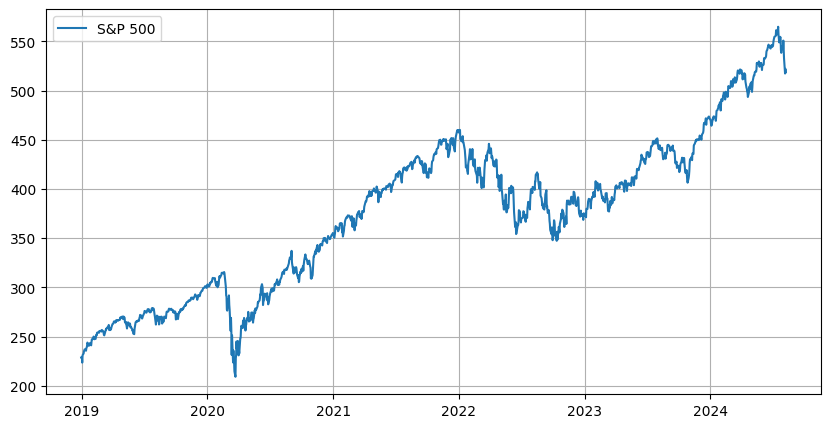

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(sp500, label="S&P 500")
plt.grid(True)
plt.legend()
plt.show()

Graficamos la serie de retornos acumulados

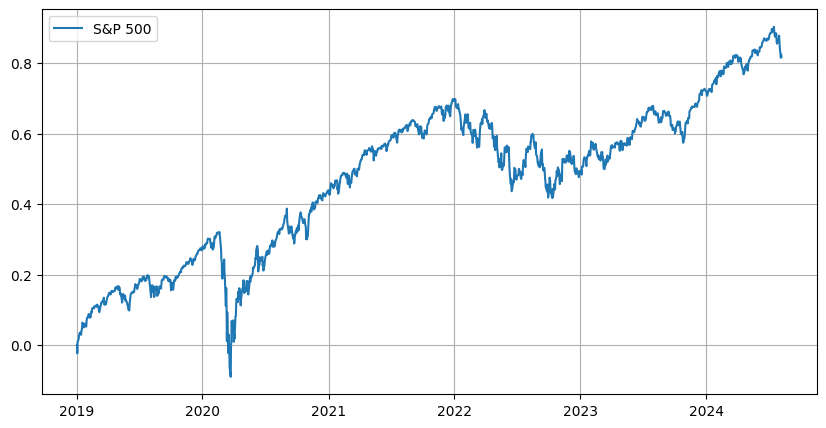

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(sp500_ret.cumsum(), label="S&P 500")
plt.grid(True)
plt.legend()
plt.show()

## ¿Qué es una ventana móvil?

Se puede definir una ventana móvil como un subconjunto de los datos originales de tamaño $w$ sobre el que se aplica una operación de reducción (media, suma, desviación típica...) que produce un único resultado. Esta ventana se mueve hacia adelante respecto al índice y se vuelve a aplicar la operación de reducción. Este proceso se repite hasta que no quedan datos que procesar.


<img src="../imgs/Tema 2 - Caso 4 - Ventana Movil.png">

Veamos un ejemplo con la **media** calculada con una **ventana móvil** de **tamaño 5**.

Ref.:
* Función **rolling**: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

In [16]:
df = pd.DataFrame(
    {
        "SP500": sp500["SP500"],
        "SMA": sp500["SP500"].rolling(window=5).mean()
    }
)
df.head(10)

,SP500,SMA
Date,,
2018-12-31,228.866135,NaN
2019-01-02,229.104202,NaN
2019-01-03,223.637177,NaN
2019-01-04,231.128006,NaN
2019-01-07,232.950378,229.137180
2019-01-08,235.139038,230.391760
2019-01-09,236.237991,231.818518
2019-01-10,237.071304,234.505344
2019-01-11,237.162872,235.712317


## ¿Cuáles son los tipos principales de medias móviles?

* **Media Móvil Simple** (Simple Moving Average - SMA): todos los datos de la ventana tienen el mismo peso o importancia.
* **Media Móvil Exponencial** (Exponential Moving Average - EMW): los datos más recientes tienen más peso o importancia que los más lejanos en el tiempo.

Ref.:
* Función **ewm**: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html

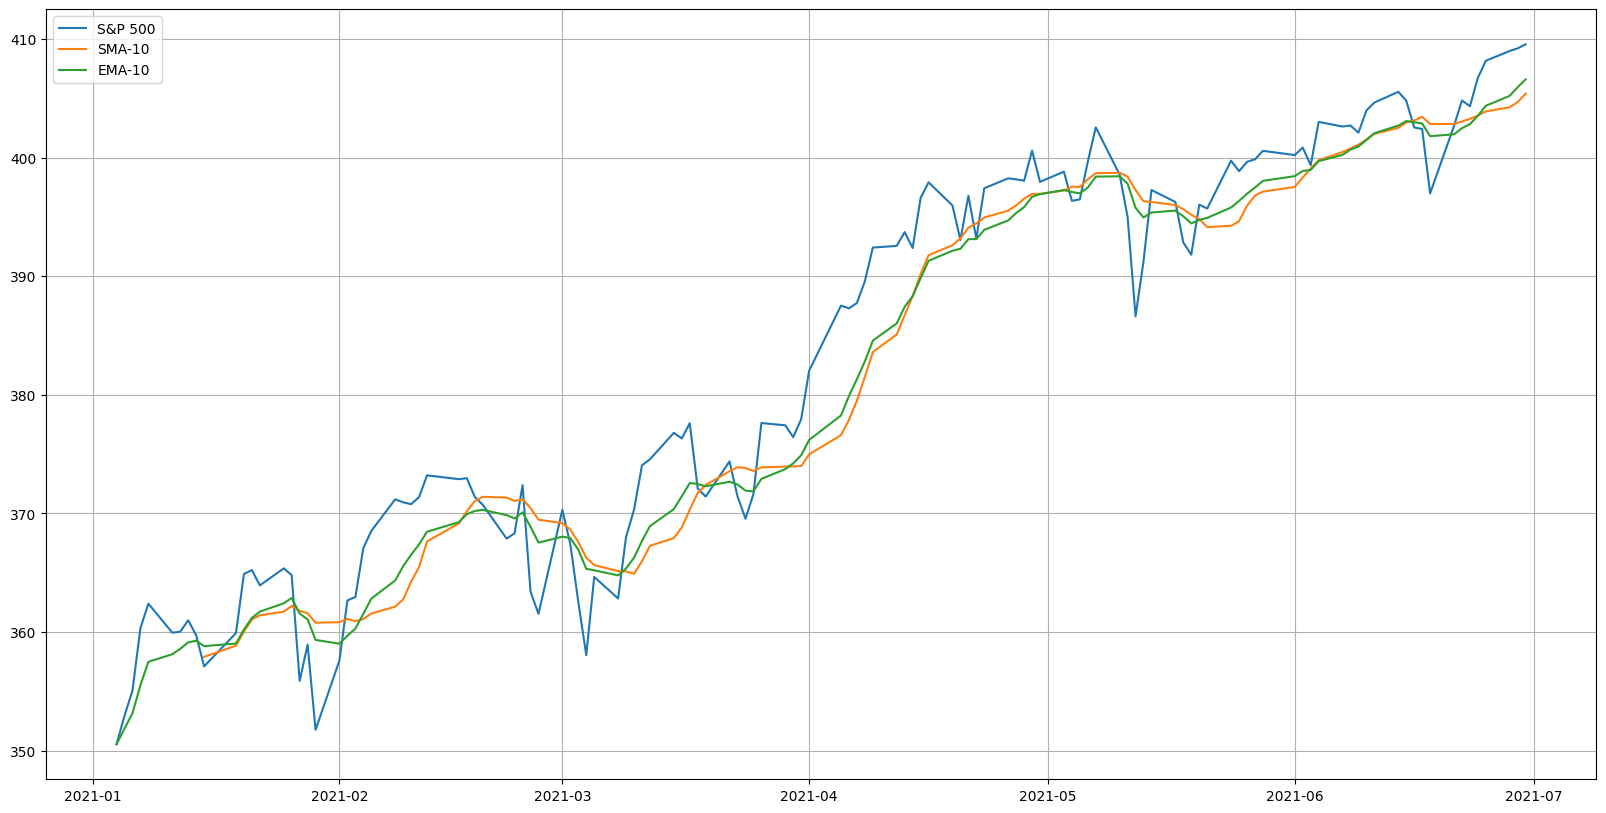

In [17]:
serie = sp500.loc["2021-01":"2021-06", :]

plt.figure(figsize=(20, 10))
plt.plot(serie, label="S&P 500")
plt.plot(serie.rolling(window=10).mean(), label="SMA-10")
plt.plot(serie.ewm(span=10).mean(), label="EMA-10")
plt.grid(True)
plt.legend()
plt.show()

## ¿Para qué se utilizan las medias móviles en trading?

Fundamentalmente para:
1. **Detectar tendencias** en los activos.
2. **Suavizar el ruido** de los precios.

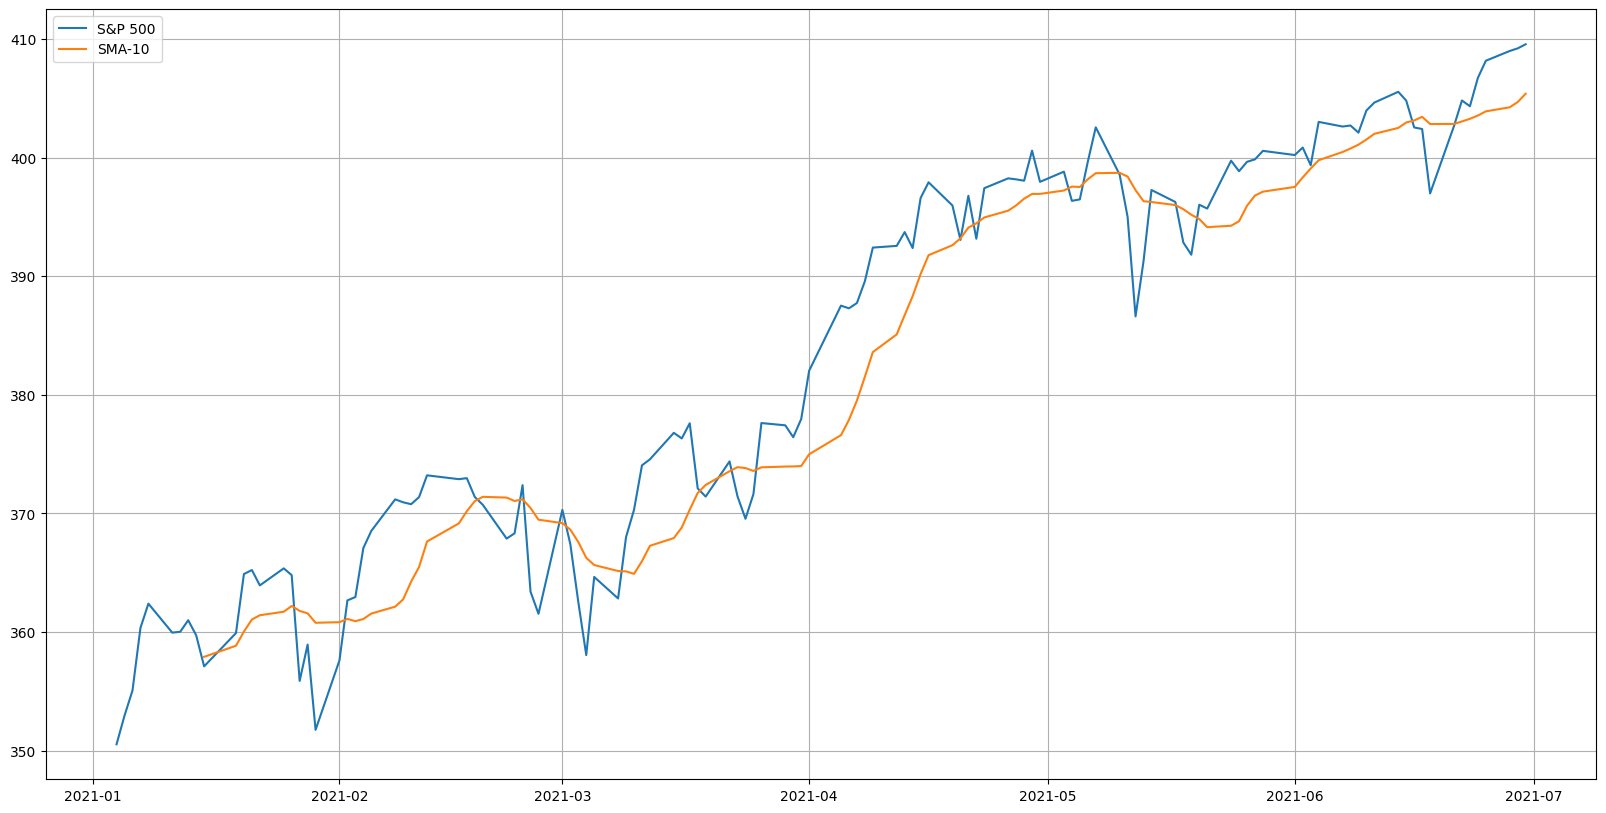

In [18]:
serie = sp500.loc["2021-01":"2021-06", :]

plt.figure(figsize=(20, 10))
plt.plot(serie, label="S&P 500")
plt.plot(serie.rolling(10).mean(), label="SMA-10")
plt.grid(True)
plt.legend()
plt.show()

## Bandas Bollinger

* SMA de 20 días.
* +/- 2 desviaciones típicas rolling.

Ref.:
* Bandas Bollinger: https://www.tecnicasdetrading.com/2024/01/bandas-de-bollinger-python-con-pandas-numpy.html

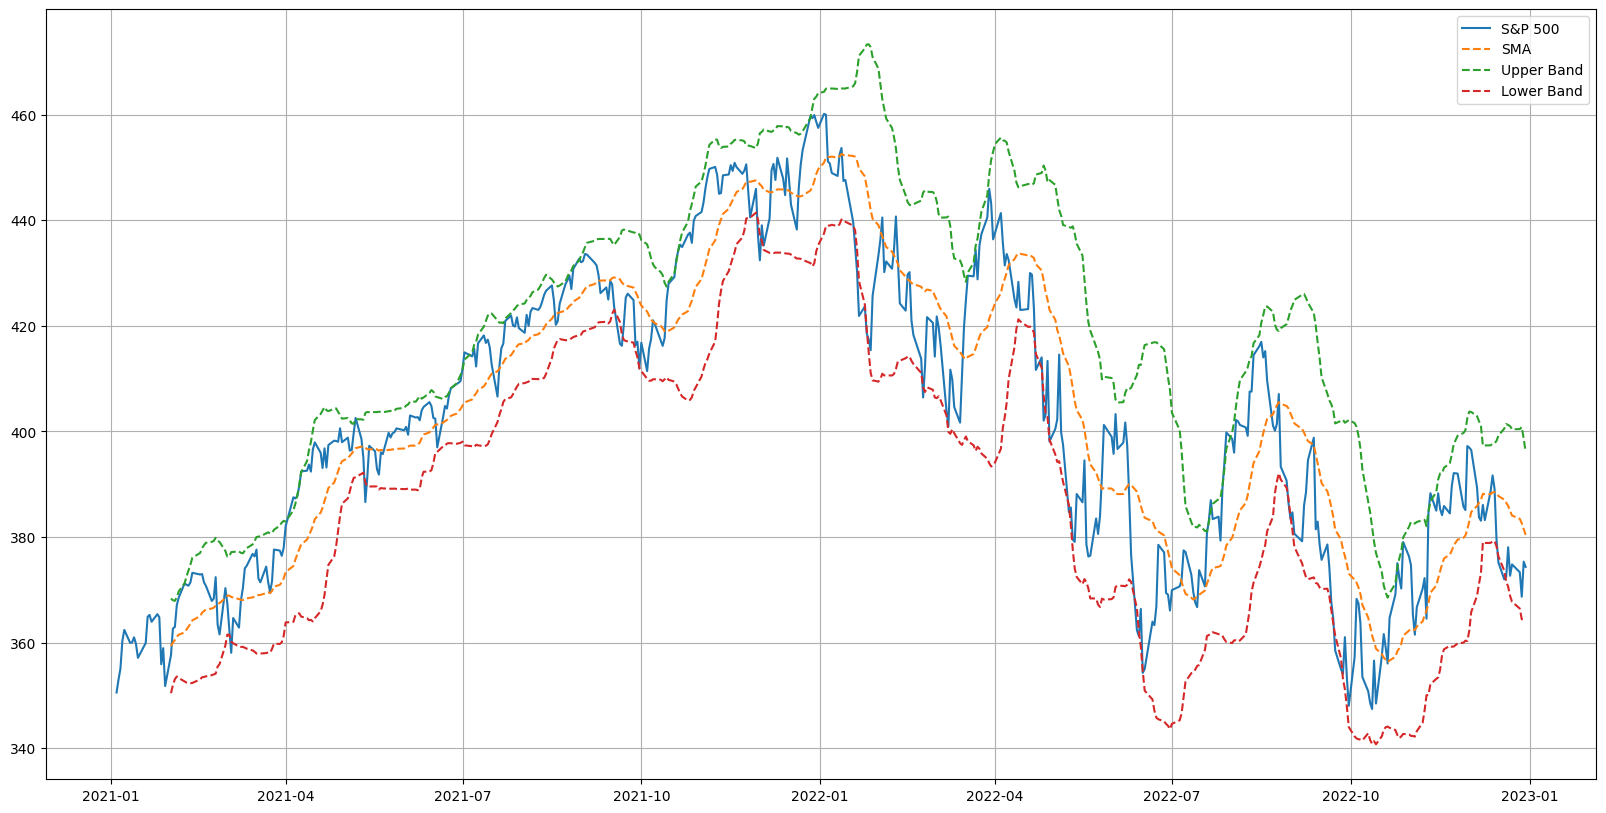

In [49]:
w = 20
data = sp500.loc["2021":"2022", :].copy()
data["SMA"] = data["SP500"].rolling(window=w).mean()
data["std"] = data["SP500"].rolling(window=w).std()
data["UpperBand"] = data["SMA"] + 2 * data["std"]
data["LowerBand"] = data["SMA"] - 2 * data["std"]

plt.figure(figsize=(20, 10))
plt.plot(data["SP500"], label="S&P 500")
plt.plot(data["SMA"], label="SMA", linestyle="--")
plt.plot(data["UpperBand"], label="Upper Band", linestyle="--")
plt.plot(data["LowerBand"], label="Lower Band", linestyle="--")
plt.grid(True)
plt.legend()
plt.show()

## Estrategia *crossover* con una *SMA-Short* y una *SMA-Long*

Consiste en combinar una media móvil con una ventana pequeña que reacciona antes a los cambios (SMA-Short), y una media móvil con una ventana grande que detecta tendencias a largo plazo (SMA-Long). Utilizaremos los cortes de la SMA-Short con la SMA-Long para generar de señales de compra y venta:

* Cuando SMA-Short corta SMA-Long hacia arriba: compramos.
* Cuando SMA-Short corta SMA-Long hacia abajo: vendemos.

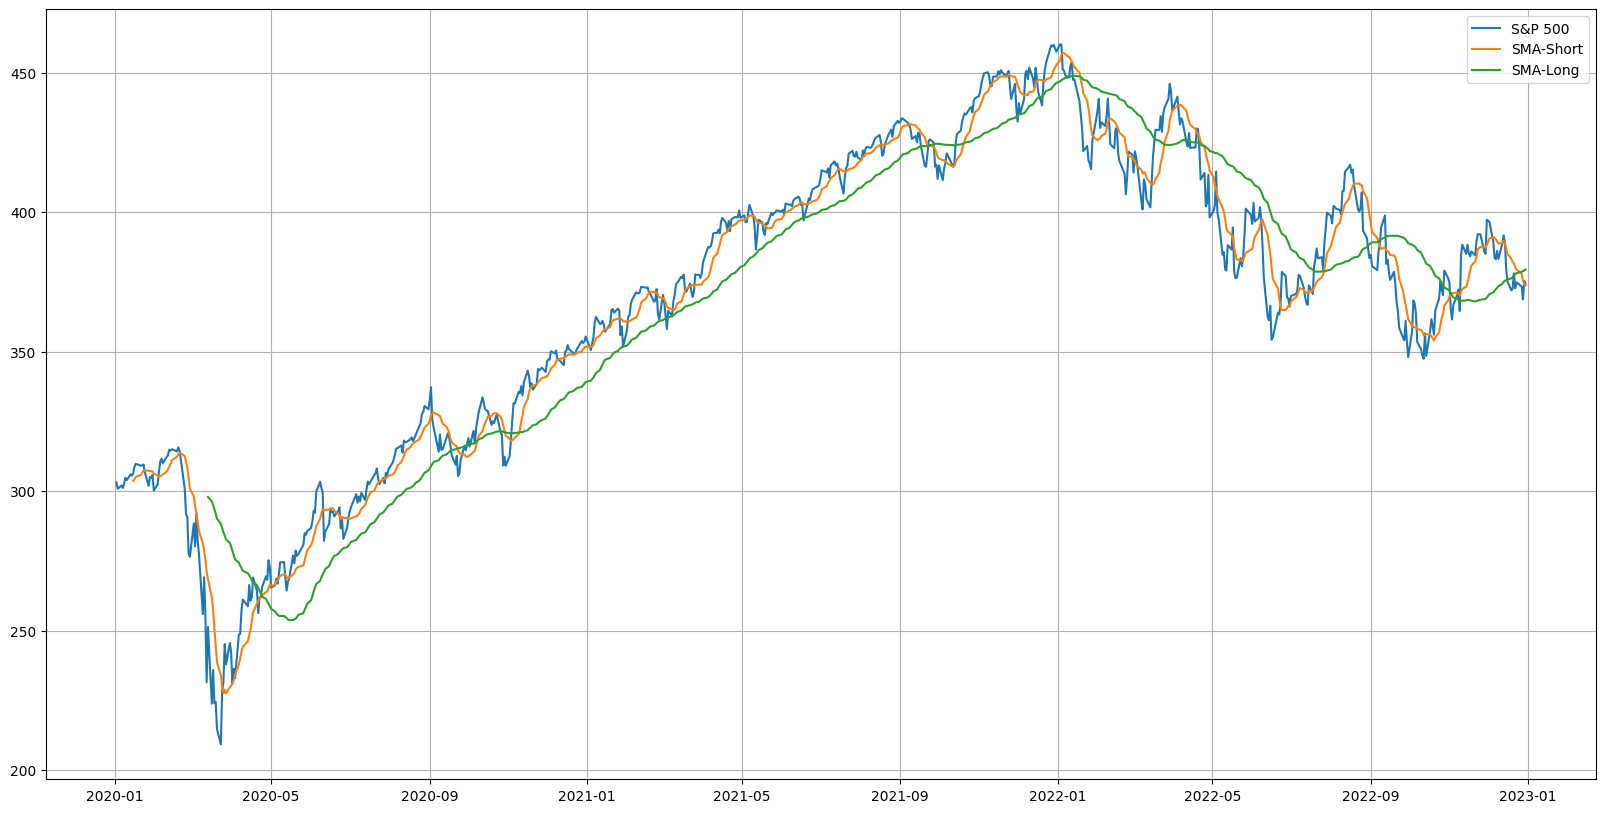

In [31]:
serie = sp500.loc["2020":"2022", :]

plt.figure(figsize=(20, 10))
plt.plot(serie, label="S&P 500")
plt.plot(serie.rolling(10).mean(), label="SMA-Short")
plt.plot(serie.rolling(50).mean(), label="SMA-Long")
plt.grid(True)
plt.legend()
plt.show()

In [20]:
def generar_senales_compra_venta(short:pd.Series, long:pd.Series) -> pd.DataFrame:
    """Genera las señales de compra (+1.0) y venta (-1.0) en función de dos
    medias móviles con dos tamaños de ventana distintos.

    Args:
        short (pd.Series): SMA-Short
        long (pd.Series): SMA-Long

    Returns:
        pd.DataFrame: ["short", "long", "signal"]
    """
    # Concatenamos las dos series por columnas en un solo dataframe.
    data = pd.concat([short, long], axis=1)
    # Renombramos las columnas.
    data.columns = ["short", "long"]
    # Calculamos la diferencia entre las dos medias móviles.
    data["diff"] = data["short"] - data["long"]
    # Generamos las señales de compra y venta.
    data.loc[data["diff"] <= 0, ["diff"]] = 0
    data.loc[data["diff"] > 0, ["diff"]] = 1
    data["diff_shift1"] = data["diff"].shift(1)
    data["signal"] = data["diff"] - data["diff_shift1"]
    # Eliminamos las columnas auxiliares y devolvemos el dataframe.
    return data.loc[:, ["short", "long", "signal"]]

def graficar_senales_compra_venta(data:pd.DataFrame, base_label:str, short_label:str, long_label:str, buy_label:str, sell_label:str):
    """Genera un gráfico con las series de datos y las señales de compra y venta.

    Args:
        data (pd.DataFrame): DataFrame con las columnas ["base", "short", "long", "signal"]
        base_label (str): Etiqueta para la serie base de precios.
        short_label (str): Etiqueta para la serie que representa la media móvil de período corto.
        long_label (str): Etiqueta para la series que representa la media móvil de período largo.
        buy_label (str): Etiqueta para la serie de señales de compra.
        sell_label (str): Etiqueta para la setie de señales de venta.
    """
    plt.figure(figsize=(20, 10))
    plt.plot(data["base"], label=base_label, zorder=1)
    plt.plot(data["short"], label=short_label, zorder=2)
    plt.plot(data["long"], label=long_label, zorder=3)
    plt.scatter(
        data.loc[data["signal"] == 1].index,
        data.loc[data["signal"] == 1, ["long"]],
        marker="^",
        edgecolor="black",
        linewidth=1,
        color="green",
        label=buy_label,
        zorder=4,
    )
    plt.scatter(
        data.loc[data["signal"] == -1].index,
        data.loc[data["signal"] == -1, ["long"]],
        marker="v",
        edgecolor="black",
        linewidth=1,
        color="red",
        label=sell_label,
        zorder=5,
    )
    plt.grid(True)
    plt.legend()
    plt.show()


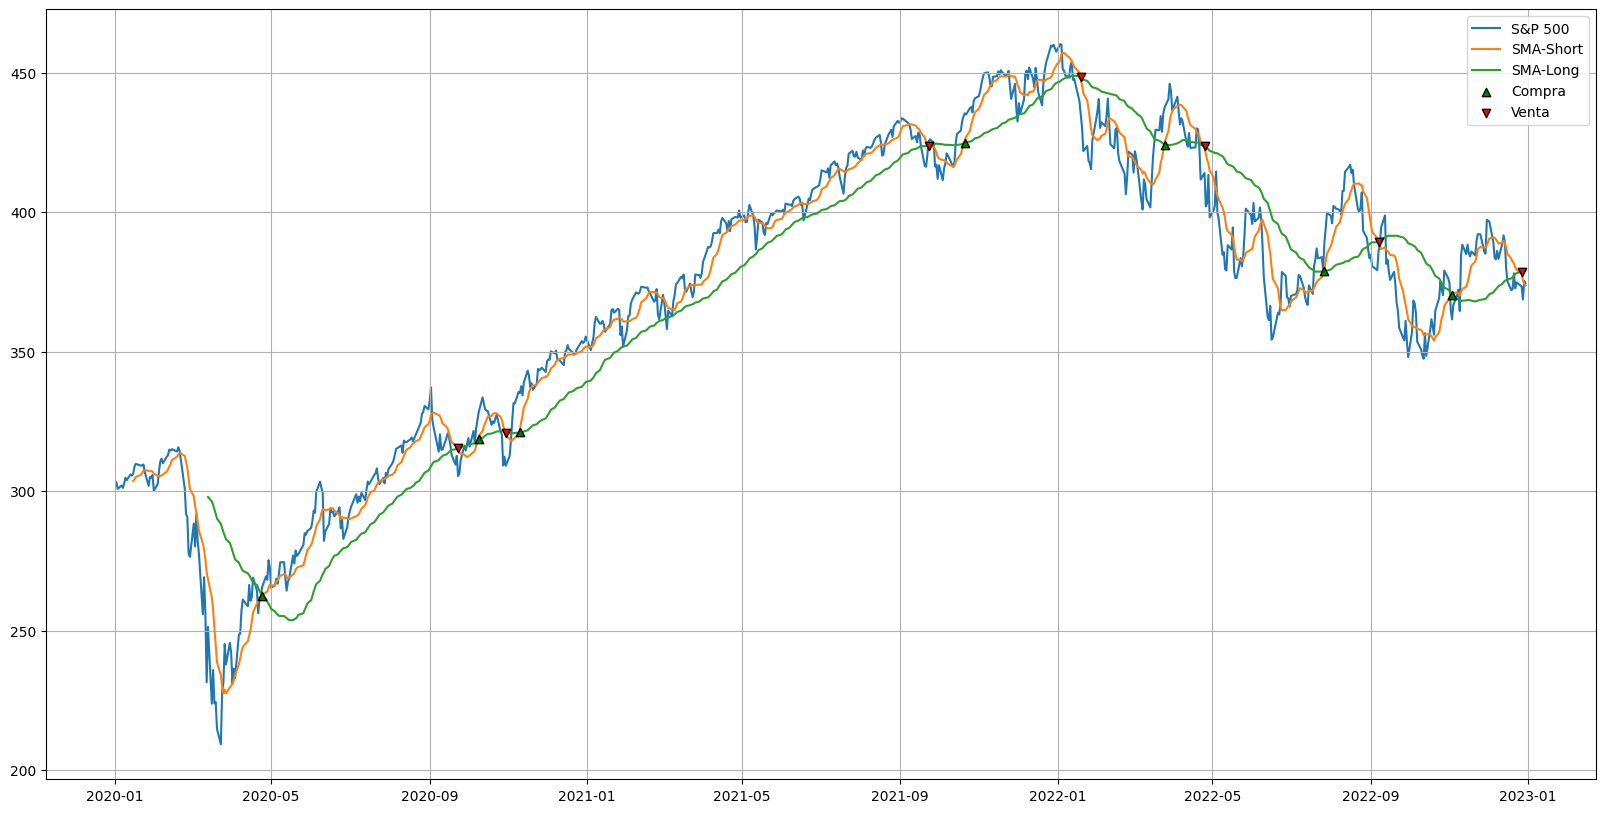

In [34]:
serie = sp500.loc["2020":"2022", :]
short = serie.rolling(10).mean()
long = serie.rolling(50).mean()

data = generar_senales_compra_venta(short, long)

data["base"] = serie["SP500"]

graficar_senales_compra_venta(data, "S&P 500", "SMA-Short", "SMA-Long", "Compra", "Venta")

## Estrategia *crossover* con una *EWM-Short* y una *SMA-Long*

Consiste en combinar una media móvil exponencial con una ventana pequeña que reacciona antes a los cambios (EWM-Short), y una media móvil con una ventana grande que detecta tendencias a largo plazo (SMA-Long). Utilizaremos los cortes de la EWM-Short con la SMA-Long para generar de señales de compra y venta:

* Cuando EWM-Short corta SMA-Long hacia arriba: compramos.
* Cuando EWM-Short corta SMA-Long hacia abajo: vendemos.

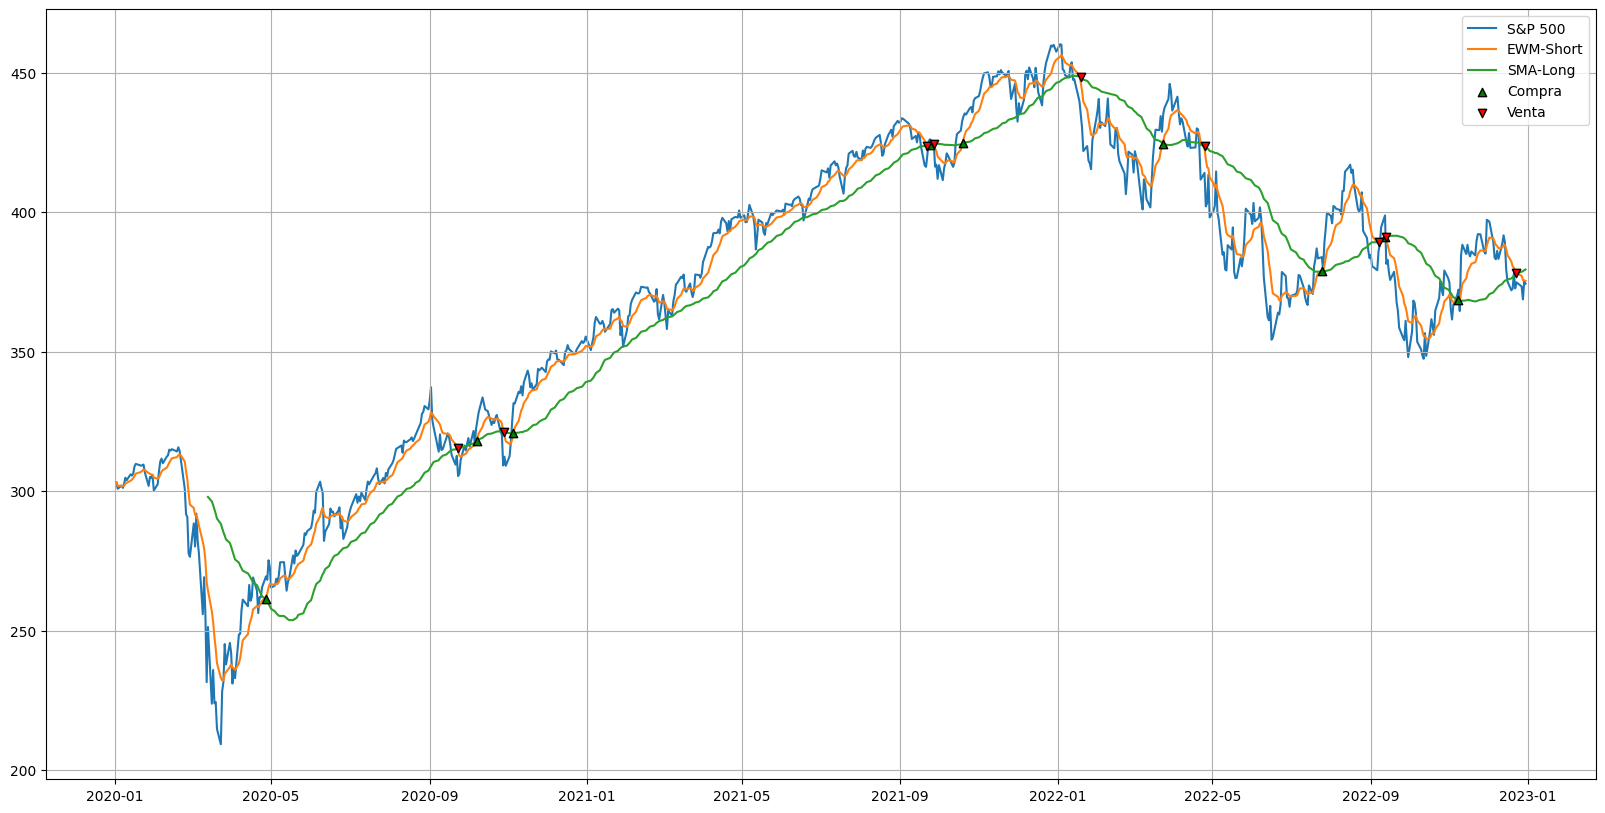

In [35]:
serie = sp500.loc["2020":"2022", :]
short = serie.ewm(span=10).mean()
long = serie.rolling(window=50).mean()

data = generar_senales_compra_venta(short, long)

data["base"] = serie["SP500"]

graficar_senales_compra_venta(
    data=data,
    base_label="S&P 500",
    short_label="EWM-Short",
    long_label="SMA-Long",
    buy_label="Compra",
    sell_label="Venta"
)